## Basic feature selection and classifier building

In [2]:
import sys
sys.path.append("..")
from src.utils.expts import Expt

In [3]:
expt = Expt("180531Thu_Model")

/Users/User1/DS/aibs/data/180531Thu_Model created
/Users/User1/DS/aibs/results/180531Thu_Model created


In [8]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Upload cleaned data into dataframe
df = pd.read_csv("../data/df_munged.csv",index_col=0)

In [16]:
# Observe samples 
df.head()

,_id,bif_ampl_local,branch_Order,contraction,depth,diameter,eucDistance,fractal_Dim,fragmentation,height,...,neuron_id,neuron_name,partition_asymmetry,pathDistance,pk_classic,soma_Surface,surface,volume,width,transmitter
11471,5afb21a69d477a8da41178ac,94.4134,10,0.753612,140.04,1.0,352.045,1.11215,183,331.790,...,11471,Cha-F-000000,0.521805,658.666,2.0,NaN,4633.22,1158.310,146.8900,cholinergic
11472,5afb21a69d477a8da41178ad,95.1149,6,0.704389,81.96,1.0,315.493,1.15950,88,320.040,...,11472,Cha-F-000001,0.833333,504.262,2.0,NaN,2098.08,524.520,45.6000,cholinergic
11473,5afb21a69d477a8da41178ae,96.9286,1,0.740006,25.55,1.0,186.726,1.09669,40,182.700,...,11473,Cha-F-000002,0.000000,308.417,2.0,NaN,1015.16,253.790,31.5597,cholinergic
11474,5afb21a69d477a8da41178af,95.0539,3,0.785272,141.91,1.0,303.061,1.05653,89,274.832,...,11474,Cha-F-000003,0.666667,665.788,2.0,NaN,3130.82,782.704,267.3200,cholinergic
11475,5afb21a69d477a8da41178b0,108.3990,12,0.741933,89.89,1.0,204.131,1.10625,192,211.160,...,11475,Cha-F-000004,0.570648,527.241,2.0,NaN,4646.68,1161.670,156.6300,cholinergic


In [28]:
# Visualize numerical features
for i,a in enumerate(df.columns): 
    print(i,a)

0 _id
1 bif_ampl_local
2 branch_Order
3 contraction
4 depth
5 diameter
6 eucDistance
7 fractal_Dim
8 fragmentation
9 height
10 length
11 n_bifs
12 n_branch
13 n_stems
14 neuron_id
15 neuron_name
16 partition_asymmetry
17 pathDistance
18 pk_classic
19 soma_Surface
20 surface
21 volume
22 width
23 transmitter


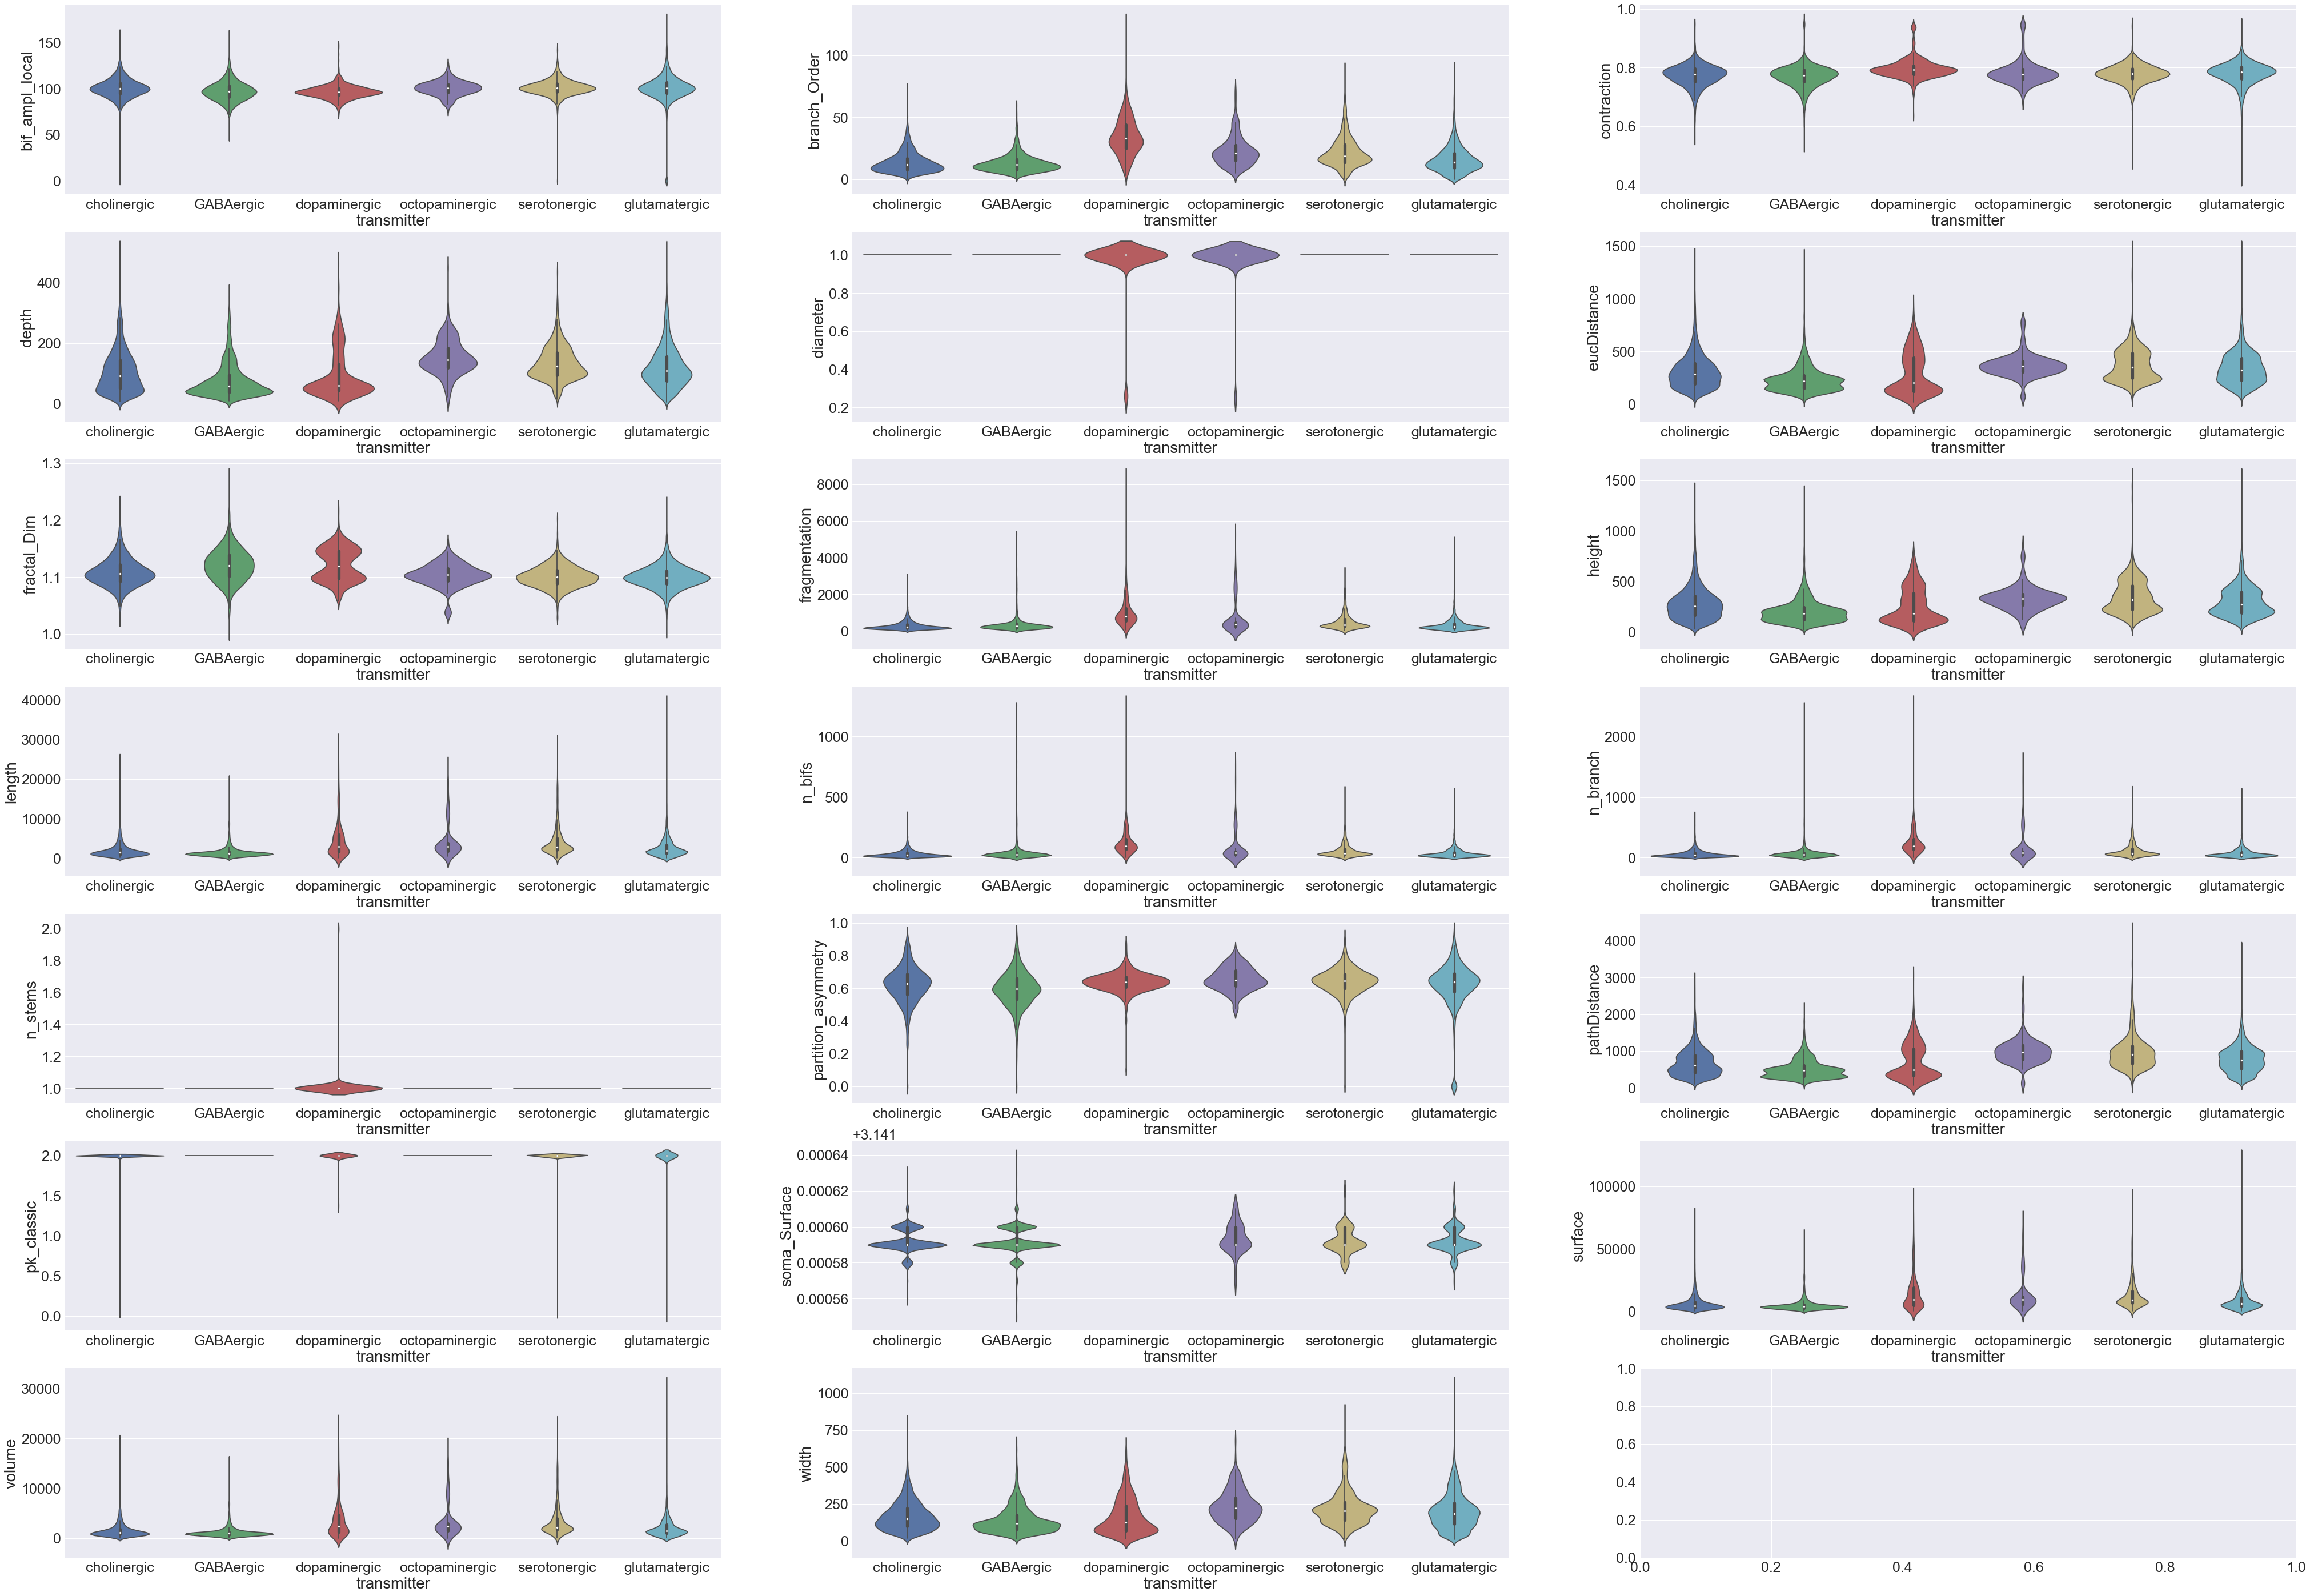

In [25]:
numeric_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22]

sns.set(font_scale=2.5)
fig, ax = plt.subplots(int(len(numeric_features)/3)+1,3,figsize=(70,50))
axs = ax.flatten()
for i,a in enumerate(numeric_features): 
    sns.violinplot(x="transmitter", y=df.columns[a], data=df, ax=axs[i])

In [21]:
df.transmitter.value_counts()

glutamatergic     6016
GABAergic         3701
cholinergic       3379
serotonergic      2212
dopaminergic       862
octopaminergic     271
Name: transmitter, dtype: int64

## Basic classifier modeling

In [36]:
from sklearn.model_selection import cross_val_score, train_test_split

In [43]:
# Separate data into X, y 
X = df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,13,16,17,18,20,21]]
y = df.transmitter

In [55]:
# Scale data for clustering
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_s = s_scaler.fit_transform(X)

In [56]:
# Reserve out of sample test data 
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=.2, random_state=1)
X_cv_s, X_test_s, _, _ = train_test_split(X_s, y, test_size=.2, random_state=1)

### Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
rfmodel = RandomForestClassifier(n_estimators=100)
rfscores = cross_val_score(rfmodel, X_cv, y_cv, cv=10)

In [47]:
rfscores.mean()

0.5975513094378507

#### Order of "feature importances"

In [48]:
rfmodel.fit(X_cv, y_cv)
sorted_features = sorted(list(zip(rfmodel.feature_importances_,X_cv.columns)))
for a in sorted_features:
    print(a)

(0.0, 'n_stems')
(8.405276893430059e-05, 'pk_classic')
(0.00014812637534672757, 'diameter')
(0.05149799791894929, 'branch_Order')
(0.05484362686047345, 'partition_asymmetry')
(0.06147170805348944, 'bif_ampl_local')
(0.06209099152201489, 'volume')
(0.06297046825471575, 'contraction')
(0.06795171233848431, 'n_bifs')
(0.06806662674905882, 'surface')
(0.06926969870439478, 'fractal_Dim')
(0.07098353277464492, 'length')
(0.07582703285561229, 'height')
(0.07770257632543473, 'eucDistance')
(0.08581842434411219, 'pathDistance')
(0.08615944689437645, 'depth')
(0.10511397725995769, 'fragmentation')


### Logistic Regression 

In [49]:
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression()
lrscores = cross_val_score(lrmodel, X_cv, y_cv, cv=10)

In [50]:
lrscores.mean()

0.5285166513004871

### K nearest neighbors

In [57]:
from sklearn.neighbors import KNeighborsClassifier
knnmodel = KNeighborsClassifier(n_neighbors=6)
knnscores = cross_val_score(knnmodel, X_cv_s, y_cv, cv=10)
knnscores.mean()

0.5222737162834565

### Support vector machine

In [59]:
from sklearn.svm import SVC
svcmodel = SVC()
svcscores = cross_val_score(svcmodel, X_cv_s, y_cv, cv=10)
svcscores.mean()

0.5630393059273192

### Gradient boosting 

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

In [62]:
gbmodel = GradientBoostingClassifier()
gbscores = cross_val_score(gbmodel, X_cv, y_cv, cv=10)

In [63]:
gbscores.mean()

0.5809059613897041

In [64]:
df.transmitter.value_counts(normalize=True)

glutamatergic     0.365914
GABAergic         0.225108
cholinergic       0.205523
serotonergic      0.134542
dopaminergic      0.052430
octopaminergic    0.016483
Name: transmitter, dtype: float64

### Observations 
In this first-pass exploration, the models performances fall in the accuracy range of .52 -.60.  Given 6 labels to choose from, the models are doing some work.  However, I still don't know now the neurotransmitter label was derived (it was either done experimentally by the researcher or analytically by neuromorpho).  

### Further steps
- Feature engineering beyond the morphometry data given. 
- Dig deeper into models with hyperparameter tuning.  